In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [34]:
TICKERS = [
    "RELIANCE.NS",
    "TCS.NS",
    "INFY.NS",
    "HDFCBANK.NS",
    "LT.NS",
    "TATAMOTORS.NS",
    "JUBLFOOD.NS",
    "ZOMATO.NS",
    "DELHIVERY.NS",
    "BAJFINANCE.NS",
    "HDFC.NS",
    "ICICIBANK.NS",
    "SBIN.NS",
]
DAYS_HISTORY = 365  # lookback for prices
TOP_N = 7
END = datetime.today()
START = END - timedelta(days=DAYS_HISTORY)

In [35]:
def safe_download(ticker, start, end):
    """Download prices and return closing series (or None)."""
    try:
        df = yf.download(ticker, start=start, end=end, progress=False, threads=False)
        if df is None or df.empty:
            return None
        return df["Close"].dropna()
    except Exception as e:
        print(f"Download error for {ticker}: {e}")
        return None

In [36]:
def pct_return_from_days(close_series, lookback_days):
    """Approx pct return over approx lookback_days (using last available points).
    Uses index-based selection; if not enough history returns np.nan."""
    if close_series is None or len(close_series) < 2:
        return np.nan
    # approximate number of trading days for lookback_days (~calendar days)
    # we'll convert calendar days to close index by searching for date
    try:
        end_date = close_series.index[-1]
        start_date = end_date - pd.Timedelta(days=lookback_days)
        # pick most recent value on/after start_date
        before = close_series[close_series.index <= start_date]
        if not before.empty:
            start_price = before.iloc[-1]
        else:
            # fallback: use earliest available
            start_price = close_series.iloc[0]
        return (float(close_series.iloc[-1]) / float(start_price) - 1.0) * 100.0
    except Exception:
        return np.nan

In [37]:
def annualized_vol_pct(close_series, window_days=30):
    """Annualized volatility (%) computed from log returns using a rolling window."""
    if close_series is None or len(close_series) < 2:
        return np.nan
    logret = np.log(close_series / close_series.shift(1)).dropna()
    if len(logret) < 2:
        return np.nan
    # use last 'window_days' observations (if available)
    window = min(len(logret), window_days)
    vol = logret[-window:].std()
    return float(vol * np.sqrt(252) * 100.0)

In [38]:
def fetch_info(ticker):
    """Return yfinance Ticker.info dict (best-effort)."""
    try:
        tk = yf.Ticker(ticker)
        return tk.info or {}
    except Exception:
        return {}

In [39]:
rows = []
for t in TICKERS:
    print("Fetching:", t)
    close = safe_download(t, START, END)
    if close is None or close.empty:
        print("  -> No price data, skipping.")
        continue

    last = float(close.iloc[-1])
    r_1m = pct_return_from_days(close, 30)  # ~1 month
    r_3m = pct_return_from_days(close, 90)  # ~3 months
    r_6m = pct_return_from_days(close, 180)  # ~6 months
    vol30 = annualized_vol_pct(close, window_days=30)

    info = fetch_info(t)
    market_cap = info.get("marketCap", np.nan)
    trailing_pe = info.get("trailingPE", np.nan)
    sector = info.get("sector", None)
    short_name = info.get("shortName", t)

    # simple momentum score (weighted returns / vol)
    if np.isnan([r_1m, r_3m, r_6m, vol30]).any():
        momentum = np.nan
    else:
        weighted_ret = (
            0.5 * (r_6m if not np.isnan(r_6m) else 0.0)
            + 0.3 * (r_3m if not np.isnan(r_3m) else 0.0)
            + 0.2 * (r_1m if not np.isnan(r_1m) else 0.0)
        )
        momentum = weighted_ret / (vol30 + 1e-9)

    rows.append(
        {
            "ticker": t,
            "name": short_name,
            "last_close": last,
            "1m_return%": r_1m,
            "3m_return%": r_3m,
            "6m_return%": r_6m,
            "vol30_ann%": vol30,
            "momentum": momentum,
            "market_cap": market_cap,
            "pe": trailing_pe,
            "sector": sector,
        }
    )

df = pd.DataFrame(rows).set_index("ticker")
df

Fetching: RELIANCE.NS
Fetching: TCS.NS
Fetching: INFY.NS
Fetching: HDFCBANK.NS
Fetching: LT.NS
Fetching: TATAMOTORS.NS
Fetching: JUBLFOOD.NS



1 Failed download:
['ZOMATO.NS']: YFTzMissingError('possibly delisted; no timezone found')


Fetching: ZOMATO.NS
  -> No price data, skipping.
Fetching: DELHIVERY.NS
Fetching: BAJFINANCE.NS



1 Failed download:
['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


Fetching: HDFC.NS
  -> No price data, skipping.
Fetching: ICICIBANK.NS
Fetching: SBIN.NS


,name,last_close,1m_return%,3m_return%,6m_return%,vol30_ann%,momentum,market_cap,pe,sector
ticker,,,,,,,,,,
RELIANCE.NS,RELIANCE INDUSTRIES LTD,1546.599976,5.555557,9.750215,8.829327,16.735379,0.504969,20930092859392,25.188925,Energy
TCS.NS,TATA CONSULTANCY SERV LT,3150.600098,4.785983,3.547834,-8.914634,16.784288,-0.145122,11399146242048,23.040808,Technology
INFY.NS,INFOSYS LIMITED,1545.000000,6.537087,5.455610,1.656648,22.794640,0.165496,6404504027136,22.125160,Technology
HDFCBANK.NS,HDFC BANK LTD,998.049988,-0.957629,1.603380,4.627701,11.151052,0.233461,15349747548160,22.833448,Financial Services
LT.NS,LARSEN & TOUBRO LTD.,4024.899902,3.515764,11.933362,12.848624,13.171439,0.812931,5536575651840,33.782944,Industrials
TATAMOTORS.NS,TATA MOTORS PASS VEH LTD,362.250000,-9.854425,-46.751432,-49.131283,149.407946,-0.271485,1494474162176,6.662016,Consumer Cyclical
JUBLFOOD.NS,JUBILANT FOODWORKS LTD,589.049988,-0.279334,-4.861509,-11.193172,28.627417,-0.248395,387298656256,129.746690,Consumer Cyclical
DELHIVERY.NS,DELHIVERY LIMITED,418.399994,-12.202286,-11.655408,18.025386,37.585768,0.081829,312869781504,232.444440,Industrials
BAJFINANCE.NS,BAJAJ FINANCE LIMITED,1004.099976,-7.583988,12.252652,9.149477,31.422019,0.214300,6240616841216,34.129840,Financial Services


In [40]:
# Z-score momentum:
df["mom_z"] = (df["momentum"] - df["momentum"].mean()) / (df["momentum"].std() + 1e-9)

In [41]:
# log market cap to reduce skew
df["mc_log"] = np.log1p(df["market_cap"].fillna(0))
df["mc_z"] = (df["mc_log"] - df["mc_log"].mean()) / (df["mc_log"].std() + 1e-9)

In [42]:
# Combined score: favor momentum, but prefer reasonable size
df["score"] = 0.75 * df["mom_z"].fillna(-3) + 0.25 * df["mc_z"].fillna(-3)

In [43]:
# Optional fundamental filter example: prefer companies with market cap > 50k Cr (50,000 Crore INR)
# Note: marketCap from yfinance is in INR for .NS tickers (best-effort). You can change threshold.
MC_THRESHOLD = 50_000 * 10**7  # 50,000 Crore = 50,000 * 10^7 = 5e11 (but check units)

In [44]:
# We will not hard-filter — instead add a bool column:
df["large_cap_flag"] = df["market_cap"].fillna(0) > MC_THRESHOLD

In [45]:
df_sorted = df.sort_values("score", ascending=False)

In [46]:
# ---------- Output ----------
print("\nTop recommendations (Indian stocks) — based on momentum + size score:\n")
display_cols = [
    "name",
    "last_close",
    "1m_return%",
    "3m_return%",
    "6m_return%",
    "vol30_ann%",
    "pe",
    "market_cap",
    "score",
    "large_cap_flag",
]
print(df_sorted[display_cols].head(TOP_N).to_string(float_format="{:.2f}".format))


Top recommendations (Indian stocks) — based on momentum + size score:

                                   name  last_close  1m_return%  3m_return%  6m_return%  vol30_ann%    pe      market_cap  score  large_cap_flag
ticker                                                                                                                                          
SBIN.NS             STATE BANK OF INDIA      972.60        7.13       19.15       23.04       13.25 10.82   8977697996800   1.84            True
LT.NS              LARSEN & TOUBRO LTD.     4024.90        3.52       11.93       12.85       13.17 33.78   5536575651840   0.89            True
RELIANCE.NS     RELIANCE INDUSTRIES LTD     1546.60        5.56        9.75        8.83       16.74 25.19  20930092859392   0.67            True
HDFCBANK.NS               HDFC BANK LTD      998.05       -0.96        1.60        4.63       11.15 22.83  15349747548160   0.22            True
BAJFINANCE.NS     BAJAJ FINANCE LIMITED     1004.10       

In [47]:
# Save results
csv_name = "indian_stock_scores.csv"
df_sorted.to_csv(csv_name)
print(f"\nFull results saved to {csv_name}")


Full results saved to indian_stock_scores.csv


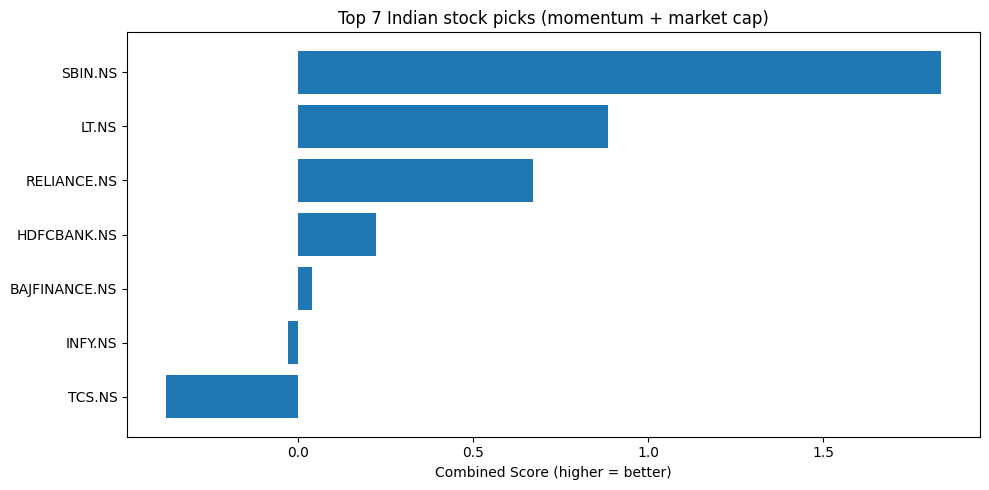

In [48]:
# ---------- Quick plot ----------
try:
    top_df = df_sorted.head(TOP_N)
    plt.figure(figsize=(10, 5))
    plt.barh(top_df.index[::-1], top_df["score"].values[::-1])
    plt.xlabel("Combined Score (higher = better)")
    plt.title(f"Top {TOP_N} Indian stock picks (momentum + market cap)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plot error:", e)